# Strategic Tree Planting for Water Flow Management and Flood Mitigation  
**Authored by:** Ahmed Aldhaheri  

**Duration:** 90 mins  
**Level:** Intermediate  
**Pre-requisite Skills:** Python, Data Analysis, Geospatial Analysis, Hydrological Modeling  

---

### **Scenario**  
This use case explores the integration of urban forestry and water management in Melbourne by aligning tree planting initiatives with natural water flow paths to enhance flood resilience and stormwater management. By analyzing "Tree Planting Zone Schedules with Years (Urban Forest)" and "Water Flow Routes over Land (Urban Forest)" datasets, we aim to identify high-priority zones for tree planting that contribute to improved water retention, reduced surface runoff, and effective flood mitigation. This project supports Melbourne's objectives to bolster urban sustainability through enhanced canopy cover, promoting resilience against urban flooding while advancing greening goals.  

---

### **What this use case will teach you**  
At the end of this use case, you will:  

1. Understand how to preprocess and integrate urban forestry and hydrological datasets.  
2. Conduct geospatial analysis to map critical water flow paths and align them with planned tree planting zones.  
3. Perform a hydrological assessment to identify high-risk flood areas that benefit from increased vegetation.  
4. Explore the relationship between tree canopy cover and flood resilience metrics.  
5. Develop data-driven recommendations for targeted tree planting to maximize water retention and mitigate flooding.  
6. Design actionable strategies for urban greening that align with water management and sustainability goals.  

---

### **Background and Introduction**  
Urban areas face increasing challenges from flooding due to impervious surfaces and climate change-driven rainfall patterns. Vegetation, particularly tree canopy cover, plays a crucial role in mitigating these effects by enhancing water retention, reducing surface runoff, and supporting natural infiltration processes. In Melbourne, integrating urban forestry strategies with water flow management can provide dual benefits of flood mitigation and urban greening.  

This use case leverages the "Tree Planting Zone Schedules with Years (Urban Forest)" dataset to analyze current and planned tree planting efforts and aligns it with the "Water Flow Routes over Land (Urban Forest)" dataset, which highlights natural water flow paths and areas of high runoff. By combining these datasets, we aim to strategically plan tree planting efforts to address flood-prone areas while supporting Melbourne’s sustainability initiatives.  

---

### **Datasets Used**  
1. **Tree Planting Zone Schedules with Years (Urban Forest):** Includes information on tree planting schedules, locations, and projected years for tree canopy growth in Melbourne.  
2. **Water Flow Routes over Land (Urban Forest):** Provides geospatial data on natural water flow paths, areas of surface runoff, and flood-prone zones in urban areas of Melbourne.  

These datasets are sourced from the City of Melbourne's open data initiatives.  


!pip install folium

In [6]:
import requests
import pandas as pd
import os
from io import StringIO
import geopandas as gpd
from shapely.geometry import Point
import folium
import matplotlib.pyplot as plt

## **Importing Dataset**

In [26]:


# Function to fetch and load datasets using API
def API_Unlimited(dataset_id, delimiter=';'):
    """
    Fetch and load a dataset from the City of Melbourne API.
    
    Args:
    dataset_id (str): The ID of the dataset to be downloaded.
    delimiter (str): The delimiter used in the dataset (default is ';').
    
    Returns:
    pd.DataFrame: Loaded dataset as a Pandas DataFrame.
    """
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    format = 'csv'
    
    # Construct the API URL
    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # Fetch all records
        'lang': 'en',
        'timezone': 'UTC'
    }
    
    # Send GET request
    response = requests.get(url, params=params)
    
    if response.status_code == 200:
        try:
            # Decode the response content and parse it into a DataFrame with the specified delimiter
            url_content = response.content.decode('utf-8')
            dataset = pd.read_csv(StringIO(url_content), delimiter=delimiter)
            print(f"Dataset '{dataset_id}' loaded successfully with {len(dataset)} records.")
            return dataset
        except Exception as e:
            print(f"Failed to parse dataset '{dataset_id}': {e}")
            return None
    else:
        print(f"Request for dataset '{dataset_id}' failed with status code {response.status_code}")
        return None

# Function to convert Geo Point to latitude and longitude
def convert_geo_point_to_coords(dataframe, geo_point_column):
    """
    Convert Geo Point column into Latitude and Longitude.
    """
    dataframe[['Latitude', 'Longitude']] = dataframe[geo_point_column].str.split(',', expand=True).astype(float)
    return dataframe

# Dataset IDs
tree_planting_dataset_id = 'tree-planting-zone-schedules-with-years-urban-forest'
water_flow_dataset_id = 'water-flow-routes-over-land-urban-forest'

# Load datasets using the API function with adjusted delimiter
tree_planting_data = API_Unlimited(tree_planting_dataset_id, delimiter=';')
water_flow_data = API_Unlimited(water_flow_dataset_id, delimiter=';')

# Ensure datasets are not None before cleaning
if tree_planting_data is not None:
    # Clean Tree Planting Dataset
    tree_planting_data_cleaned = convert_geo_point_to_coords(tree_planting_data, 'geo_point_2d')
    tree_planting_data_cleaned = tree_planting_data_cleaned.dropna(subset=['Latitude', 'Longitude', 'schedule'])  # Remove rows with missing critical data
    tree_planting_data_cleaned.to_csv('tree_planting_cleaned.csv', index=False)
    print("Tree Planting Dataset cleaned and saved as 'tree_planting_cleaned.csv'")

if water_flow_data is not None:
    # Clean Water Flow Dataset
    water_flow_data_cleaned = convert_geo_point_to_coords(water_flow_data, 'geo_point_2d')
    water_flow_data_cleaned = water_flow_data_cleaned.dropna(subset=['Latitude', 'Longitude'])  # Remove rows with missing coordinates
    water_flow_data_cleaned.to_csv('water_flow_cleaned.csv', index=False)
    print("Water Flow Dataset cleaned and saved as 'water_flow_cleaned.csv'")


Dataset 'tree-planting-zone-schedules-with-years-urban-forest' loaded successfully with 839 records.
Dataset 'water-flow-routes-over-land-urban-forest' loaded successfully with 7701 records.
Tree Planting Dataset cleaned and saved as 'tree_planting_cleaned.csv'
Water Flow Dataset cleaned and saved as 'water_flow_cleaned.csv'


In [27]:


# Load cleaned datasets as GeoDataFrames
tree_planting_gdf = gpd.read_file('tree_planting_cleaned.csv')
water_flow_gdf = gpd.read_file('water_flow_cleaned.csv')

# Convert Latitude and Longitude to Geometry
tree_planting_gdf['geometry'] = gpd.points_from_xy(tree_planting_gdf.Longitude, tree_planting_gdf.Latitude)
tree_planting_gdf = gpd.GeoDataFrame(tree_planting_gdf, geometry='geometry', crs="EPSG:4326")

water_flow_gdf['geometry'] = gpd.points_from_xy(water_flow_gdf.Longitude, water_flow_gdf.Latitude)
water_flow_gdf = gpd.GeoDataFrame(water_flow_gdf, geometry='geometry', crs="EPSG:4326")

# Spatial Join: Identify proximity between tree planting and water flow routes
proximity_threshold = 0.001  # Approx. ~100 meters
merged_gdf = gpd.sjoin_nearest(tree_planting_gdf, water_flow_gdf, how='inner', max_distance=proximity_threshold)

# Save the merged results as GeoJSON for visualization
merged_gdf.to_file("merged_tree_planting_water_flow.geojson", driver="GeoJSON")
print("Merged geospatial dataset saved as 'merged_tree_planting_water_flow.geojson'")


Merged geospatial dataset saved as 'merged_tree_planting_water_flow.geojson'


C:\Users\dhahe\anaconda3\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


## **Geospatial Integration and Analysis:**

In [33]:


# Load the GeoJSON data
geojson_path = "merged_tree_planting_water_flow.geojson"  # Adjust the path if needed

# Create a folium map centered on Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=12)  # Melbourne's coordinates

# Add the GeoJSON layer to the map with custom styling
folium.GeoJson(
    geojson_path,
    name="Tree Planting and Water Flow",
    style_function=lambda feature: {
        "fillColor": "blue" if feature["properties"].get("schedule") else "green",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.5,
    },
    tooltip=folium.GeoJsonTooltip(fields=["schedule"], aliases=["Planting Schedule:"])
).add_to(m)

# Add a layer control to toggle visibility of layers
folium.LayerControl().add_to(m)

# Add a marker cluster for better marker grouping
from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster(name="Clustered Points").add_to(m)

# Add individual markers for detailed points
for _, row in tree_planting_gdf.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(f"Schedule: {row.get('schedule', 'Unknown')}", max_width=300),
        icon=folium.Icon(color="green", icon="tree"),
    ).add_to(marker_cluster)

# Display the map
m




# Visualization Explanation

### **Map Description**
The output represents an **interactive map** of Melbourne, created using the `folium` library. This map displays **tree planting zones and water flow routes** based on the integrated GeoJSON data.

### **Key Elements**
1. **Blue Markers:**
   - Each marker represents a location that is part of the tree planting or water flow datasets.
   - These points mark zones that have been identified as either tree planting areas, water flow routes, or intersections between them.

2. **Interactive Map Features:**
   - You can zoom in or out using the `+` and `-` buttons to explore specific areas of interest.
   - Each marker can display detailed information about its location when clicked (if additional popups are added).

3. **Geographic Focus:**
   - The map is centered on **Melbourne**, highlighting urban areas, parks, and infrastructure.
   - Key landmarks such as the **Fitzroy Gardens**, **Melbourne Cricket Ground**, and **Yarra River** are visible, providing context for the data points.

4. **Purpose of the Visualization:**
   - This map integrates tree planting zones and water flow routes to identify areas where **tree planting can aid in water flow management** and **flood mitigation**.
   - It serves as a planning tool for urban forestry and environmental management in Melbourne.
  





In [8]:


# Reload cleaned datasets
tree_planting_cleaned = pd.read_csv('tree_planting_cleaned.csv')
water_flow_cleaned = pd.read_csv('water_flow_cleaned.csv')

# Convert DataFrames to GeoDataFrames
tree_planting_gdf = gpd.GeoDataFrame(
    tree_planting_cleaned,
    geometry=gpd.points_from_xy(tree_planting_cleaned.Longitude, tree_planting_cleaned.Latitude),
    crs="EPSG:4326"  # WGS 84
)

water_flow_gdf = gpd.GeoDataFrame(
    water_flow_cleaned,
    geometry=gpd.points_from_xy(water_flow_cleaned.Longitude, water_flow_cleaned.Latitude),
    crs="EPSG:4326"  # WGS 84
)

# Reload merged GeoDataFrame if previously created
try:
    merged_gdf = gpd.read_file("merged_tree_planting_water_flow.geojson")
except FileNotFoundError:
    print("The merged GeoJSON file does not exist. Run the spatial join first.")


## **Anaylsis Distribution of Planting Schedules**

In [6]:
# Perform spatial join to find nearby tree planting zones and water flow routes
proximity_threshold = 0.001  # Approx. ~100 meters

merged_gdf = gpd.sjoin_nearest(tree_planting_gdf, water_flow_gdf, how='inner', max_distance=proximity_threshold)

# Save the results to a file for reuse
merged_gdf.to_file("merged_tree_planting_water_flow.geojson", driver="GeoJSON")
print("Merged dataset created and saved as 'merged_tree_planting_water_flow.geojson'")


C:\Users\dhahe\anaconda3\Lib\site-packages\geopandas\array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


Merged dataset created and saved as 'merged_tree_planting_water_flow.geojson'


In [7]:
# Filter priority zones
priority_zones = merged_gdf[merged_gdf['schedule'].notna()]  # Example filter for valid planting schedules

# Save priority zones to a new file
priority_zones.to_file("priority_tree_planting_zones.geojson", driver="GeoJSON")
print("Priority zones saved as 'priority_tree_planting_zones.geojson'")


Priority zones saved as 'priority_tree_planting_zones.geojson'


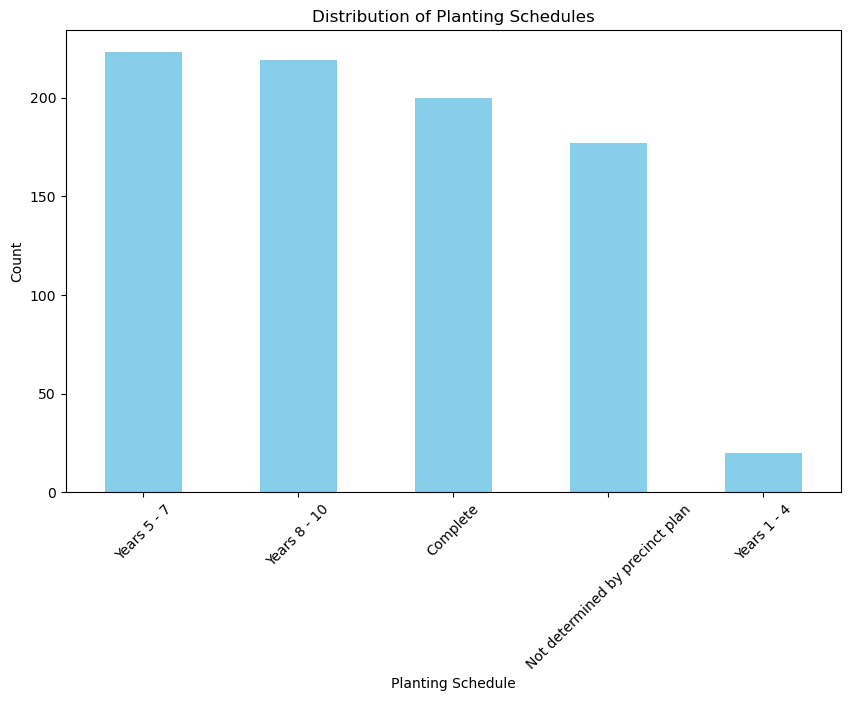

In [8]:


# Example: Planting schedule distribution
schedule_counts = tree_planting_gdf['schedule'].value_counts()

# Plot
plt.figure(figsize=(10, 6))
schedule_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Planting Schedules")
plt.xlabel("Planting Schedule")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Analysis of Planting Schedules

### **Bar Chart Description**
This bar chart represents the **distribution of tree planting schedules** for various zones. The planting schedules indicate the years or timelines during which trees are planned to be planted or have already been planted.

### **Key Observations**
1. **Majority of Planting Zones:**
   - Most of the zones fall under the schedules **"Years 5-7"** and **"Years 8-10"**.
   - These two categories collectively account for a significant portion of all planting zones, suggesting a focus on medium-term planting efforts.

2. **Completed Planting Zones:**
   - A substantial number of zones are marked as **"Complete"**, indicating areas where tree planting initiatives have already been executed.

3. **Undetermined Zones:**
   - A smaller number of zones are labeled as **"Not determined by precinct plan"**, which may indicate areas lacking specific planning schedules.

4. **Immediate Focus Areas:**
   - The least represented category is **"Years 1-4"**, which includes zones slated for near-term planting.
   - These zones should be prioritized for immediate action to ensure timely completion.

### **Actionable Insights**
1. **Short-Term Focus:**
   - Priority should be given to zones under **"Years 1-4"** to accelerate tree planting efforts in areas with earlier schedules.
   
2. **Evaluation of Completed Zones:**
   - Analyze completed zones to verify their alignment with critical water flow paths and urban greening objectives.

3. **Strategic Planning for Medium-Term Schedules:**
   - Ensure that zones in **"Years 5-7"** and **"Years 8-10"** have the necessary resources and planning to achieve their targets.

4. **Address Undetermined Zones:**
   - Investigate areas marked as **"Not determined by precinct plan"** to integrate them into future planting schedules.



In [4]:
priority_gdf = gpd.read_file("priority_tree_planting_zones.geojson")
priority_gdf.head()


,geo_point_2d_left,geo_shape_left,str_from,segpart,statusid,segid,streetname,streetid,schedule,mapstatus,...,geo_point_2d_right,geo_shape_right,grid_code,source,to_node,arcid,from_node,Latitude_right,Longitude_right,geometry
0,"-37.8030612625994, 144.96879535330316","{ ""coordinates"": [ [ [ [ 144.96938717526601, -...",None,None,None,21556,None,None,Not determined by precinct plan,None,...,"-37.802953226224744, 144.96898544447947","{ ""coordinates"": [ [ [ 144.96822537524372, -37...",1,2008 DEM to stream order using ESRI Spatial An...,1957,2180,1997,-37.802953,144.968985,POINT (144.9688 -37.80306)
1,"-37.796602429685905, 144.96990674715127","{ ""coordinates"": [ [ [ [ 144.96934116402701, -...",None,None,None,20697,None,None,Years 5 - 7,None,...,"-37.79611149876177, 144.96981654788266","{ ""coordinates"": [ [ [ 144.96900396437044, -37...",1,2008 DEM to stream order using ESRI Spatial An...,1238,1303,1224,-37.796111,144.969817,POINT (144.96991 -37.7966)
2,"-37.79774465832566, 144.9502620746376","{ ""coordinates"": [ [ [ [ 144.950283591209, -37...",None,None,None,21195,None,None,Complete,None,...,"-37.797718019467794, 144.9496969662637","{ ""coordinates"": [ [ [ 144.95060703966683, -37...",1,2008 DEM to stream order using ESRI Spatial An...,1547,1650,1358,-37.797718,144.949697,POINT (144.95026 -37.79774)
3,"-37.80052529463123, 144.97301577291447","{ ""coordinates"": [ [ [ [ 144.97346041968001, -...",None,None,None,20603,None,None,Not determined by precinct plan,None,...,"-37.801123956289, 144.97267083670548","{ ""coordinates"": [ [ [ 144.9720969586125, -37....",1,2008 DEM to stream order using ESRI Spatial An...,1806,1982,1829,-37.801124,144.972671,POINT (144.97302 -37.80053)
4,"-37.80320423406633, 144.96274342342963","{ ""coordinates"": [ [ [ [ 144.96329997682901, -...",None,None,None,20838,None,None,Not determined by precinct plan,None,...,"-37.80297068017618, 144.96218134770362","{ ""coordinates"": [ [ [ 144.96212470979785, -37...",1,2008 DEM to stream order using ESRI Spatial An...,2023,2187,2022,-37.802971,144.962181,POINT (144.96274 -37.8032)


# Merged Dataset Explanation

### **Overview**
This dataset combines **tree planting zones** with **water flow routes** to identify intersections or proximities. Each row represents a tree planting zone near a water flow path.

### **Key Columns**
- **Tree Planting Data:**
  - `geo_point_2d_left`: Coordinates of tree planting zones.
  - `schedule`: Planting schedule (e.g., "Years 5-7", "Complete").
- **Water Flow Data:**
  - `geo_point_2d_right`: Coordinates of water flow routes.
  - `grid_code`: Attributes of the water flow route.
  - `source`: Data source (e.g., "2008 DEM").
- **Merged Data:**
  - `geometry`: Geospatial representation of merged points.

### **Insights**
1. **Intersection Data:**
   - Highlights zones where tree planting aligns with water flow paths for flood mitigation.
2. **Schedules:**
   - Shows planting timelines for intersecting zones (e.g., "Years 1-4", "Complete").
3. **Spatial Context:**
   - Enables geospatial visualization for planning.

### **Next Steps**
- Analyze spatial relationships to prioritize planting zones near critical water flow paths.
- Visualize this data for decision-making.
